## Building a 'Bag of Words' Clustering Model
<br>

 - 20 newsgroups
 - kmeans
 - LSA (latent semantic analysis)

In [1]:
import pandas as pd
import numpy as np
from time import time
from matplotlib import pyplot as plt
%matplotlib inline

# make sure we display all the columns
pd.set_option('display.max_columns', 25)

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import text
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans

def fetchInputs():
    print "Loading 20 newsgroups dataset"
    dataset = fetch_20newsgroups(subset='all', categories=None, shuffle=True, random_state=42)
    labels = dataset.target
    true_k = np.unique(labels).shape[0]
    
    print "%d documents" % len(dataset.data)
    print "%d categories" % len(dataset.target_names)
    print
    return dataset.data, labels, true_k
    

def vectorizeInputs(idf, n, data):
    print "Extracting features from the training dataset using a tf-idf vectorizer"
    t0 = time()
    
    more_stop_words = set()
    with open('SuperSmartStopList.txt', 'rb') as fp:
        for line in fp:
            more_stop_words.add(line.strip())

    vectorizer = text.TfidfVectorizer(max_features=n, 
        stop_words=text.ENGLISH_STOP_WORDS.union(more_stop_words), 
        max_df=0.5, min_df=2, use_idf=idf)
    
    x = vectorizer.fit_transform(data).todense()
    terms = vectorizer.get_feature_names()

    print "done in %fs" % (time() - t0)
    print "n_samples: %d, n_features: %d" % x.shape
    print
    return x, terms


def performLSA(n, x, normalize=True, verbose=True):
    if not n:
        if verbose:
            print "Not performing dimensionality reduction. n=%d" % n
            print
        return x, None
    
    if verbose:
        print "Performing dimensionality reduction using LSA n=%d" % n
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n)
    if normalize:
        normalizer = Normalizer(copy=False)
        lsa = make_pipeline(svd, normalizer)
    else:
        lsa = svd
    x = lsa.fit_transform(x)
    if verbose:
        print "done in %fs" % (time() - t0)

    explained_variance = svd.explained_variance_ratio_.sum()
    if verbose:
        print "Explained variance of the SVD step: {}%".format(int(explained_variance * 100))
        print  
    return x, svd


def performClustering(num_clusters, data, verbose=True):
    # Note: as k-means is optimizing a non-convex objective function, it will likely end up 
    # in a local optimum. Several runs with independent random init might be necessary to 
    # get a good convergence.
    km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1, verbose=verbose)
    print "Clustering sparse data with %s" % km
    print
    t0 = time()
    km.fit(data)
    
    print "done in %0.3fs" % (time() - t0)
    print
    return km



In [41]:
# Preprocess documents with latent semantic analysis.
n_components = 100
# Disable Inverse Document Frequency feature weighting
use_idf = True
# Maximum number of features (dimensions) to extract from text
n_features = 10000

# raw inputs
data, labels, k = fetchInputs()

# tf-idf vectorization
# 
# It can be noted that k-means is very sensitive to feature scaling and 
# that in this case the IDF weighting helps improve the quality of the clustering
# by quite a lot as measured against the “ground truth” provided by the class label 
# assignments of the 20 newsgroups dataset.
_X, feature_names = vectorizeInputs(use_idf, n_features, data)

# latent sematic analysis is used to reduce dimensionality 
# and discover latent patterns in the data.
r_X, r_svd = performLSA(n_components, _X)


Loading 20 newsgroups dataset
18846 documents
20 categories

Extracting features from the training dataset using a tf-idf vectorizer
done in 6.391562s
n_samples: 18846, n_features: 10000

Performing dimensionality reduction using LSA n=100
done in 6.499228s
Explained variance of the SVD step: 14%



In [42]:
# do clustering
primary_cluster_model = performClustering(k, r_X)

# This improvement is not visible in the Silhouette Coefficient which is small 
# for both as this measure seem to suffer from the phenomenon called 
# “Concentration of Measure” or “Curse of Dimensionality” for high dimensional 
# datasets such as text data. Other measures such as V-measure and Adjusted Rand 
# Index are information theoretic based evaluation scores: as they are only based 
# on cluster assignments rather than distances, hence not affected by the curse of dimensionality.
print "Homogeneity: %0.3f" % metrics.homogeneity_score(labels, primary_cluster_model.labels_)
print "Completeness: %0.3f" % metrics.completeness_score(labels, primary_cluster_model.labels_)
print "V-measure: %0.3f" % metrics.v_measure_score(labels, primary_cluster_model.labels_)
print "Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, primary_cluster_model.labels_)
print "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(r_X, primary_cluster_model.labels_, sample_size=1000)
print

print "Top terms per cluster:"
if n_components:
    original_space_centroids = r_svd.inverse_transform(primary_cluster_model.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
else:
    order_centroids = primary_cluster_model.cluster_centers_.argsort()[:, ::-1]

for i in range(k):
    print "Cluster %d:" % i,
    for ind in order_centroids[i, :10]:
        print ' %s' % feature_names[ind],
    print
print

Clustering sparse data with KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=20, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=True)

Initialization complete
Iteration  0, inertia 22173.798
Iteration  1, inertia 14052.378
Iteration  2, inertia 13726.773
Iteration  3, inertia 13556.325
Iteration  4, inertia 13462.083
Iteration  5, inertia 13420.247
Iteration  6, inertia 13396.841
Iteration  7, inertia 13366.556
Iteration  8, inertia 13340.696
Iteration  9, inertia 13319.728
Iteration 10, inertia 13316.360
Iteration 11, inertia 13315.057
Iteration 12, inertia 13314.451
Iteration 13, inertia 13314.047
Iteration 14, inertia 13313.486
Iteration 15, inertia 13312.020
Iteration 16, inertia 13310.168
Iteration 17, inertia 13309.431
Iteration 18, inertia 13308.970
Iteration 19, inertia 13308.417
Iteration 20, inertia 13307.763
Iteration 21, inertia 13306.670
Iteration 22, inertia 13305.018
Iteration 23, inertia 13303.045
Iteration 

Clustering sparse data with KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=20, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=False)

done in 0.219s

Clustering sparse data with KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=20, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=False)

done in 0.061s



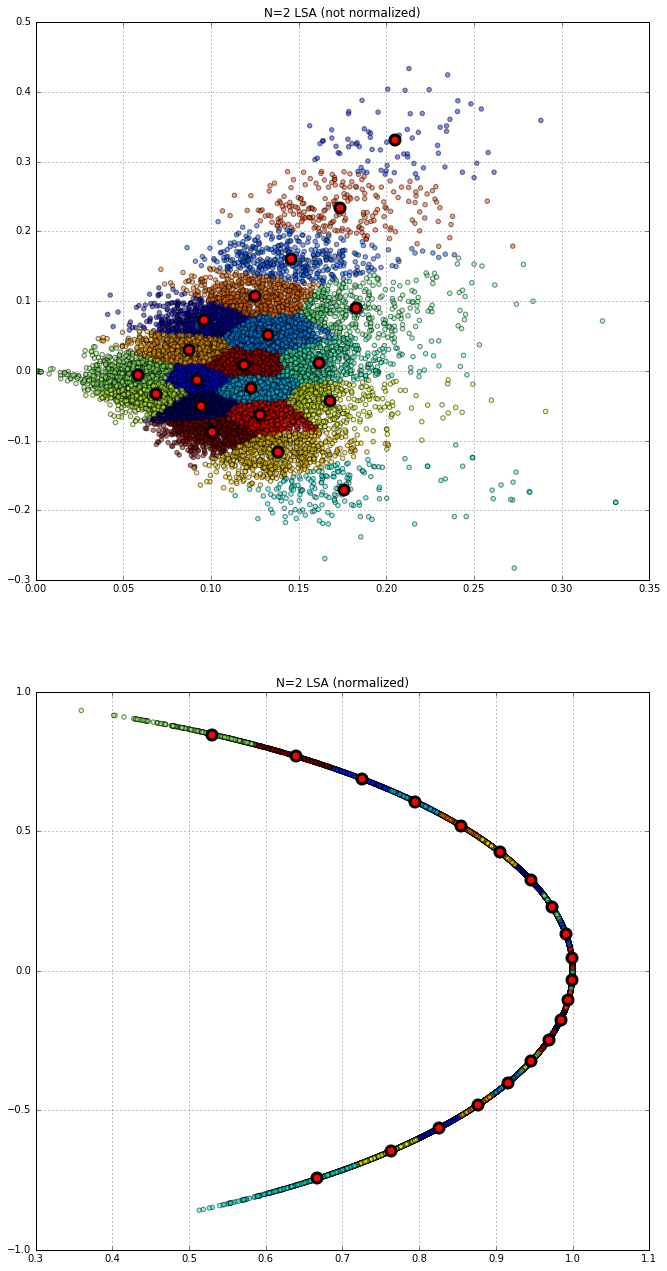

In [44]:
# latent sematic analysis can also be used to produce 
# scatter plots of clusterings
n_X, n_svd = performLSA(2, _X, verbose=False)
g_X, g_svd = performLSA(2, _X, normalize=False, verbose=False)

# graphical clustering (not normalized)
g_km = performClustering(k, g_X, verbose=False)
g_centers2D = g_km.cluster_centers_

# graphical clustering (normalized)
n_km = performClustering(k, n_X, verbose=False)
n_centers2D = n_km.cluster_centers_

fig = plt.figure(figsize=(11,22), tight_layout=False)

ax1 = plt.subplot(211)
ax1.scatter(g_X[:,0], g_X[:,1], c=g_km.labels_, alpha=0.5)
ax1.scatter(g_centers2D[:,0], g_centers2D[:,1], marker='o', s=100, linewidth=3, c='r')
ax1.grid(True)
ax1.set_xlabel('', fontsize=20)
ax1.set_ylabel('', fontsize=20)
ax1.set_xlim([0,.35])
ax1.set_ylim([-.3,.5])
ax1.set_title('N=2 LSA (not normalized)')

ax2 = plt.subplot(212)
ax2.scatter(n_X[:,0], n_X[:,1], c=n_km.labels_, alpha=0.5)
ax2.scatter(n_centers2D[:,0], n_centers2D[:,1], marker='o', s=100, linewidth=3, c='r')
ax2.grid(True)
ax2.set_xlabel('', fontsize=20)
ax2.set_ylabel('', fontsize=20)
ax2.set_ylim([-1,1])
ax2.set_title('N=2 LSA (normalized)')

plt.show()

